In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from hana_ml import dataframe
from data_load_utils import Settings

## Generate Test Series

In [7]:

def geometric_brownian_motion(T = 1, N = 2, mu = -0.01, sigma = 0.001, S0 = 2):        
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2010-01-01', '2018-03-10',freq='H')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 1000
y = pd.DataFrame()
y['INDEX'] = dates
y['Y'] = geometric_brownian_motion(T, N, sigma=0.1, S0=start_price)
y.set_index("INDEX").plot()

In [8]:

url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)


## Upload to HANA DB

In [9]:
hana_df = dataframe.create_dataframe_from_pandas(connection_context, y, 'ARIMA_TEST', force=True).sort("INDEX")

100%|████████████████████████████████████████████| 3/3 [00:07<00:00,  2.39s/it]


In [5]:
df_pal = dataframe.DataFrame(connection_context, 'select * from ARIMA_TEST').select('INDEX','Y')


In [6]:
print (df_pal.count(), df_pal.columns)

71761 ['INDEX', 'Y']


In [12]:
from hana_ml.visualizers import m4_sampling
import timeit
years = mdates.YearLocator() 

308.65884926891886


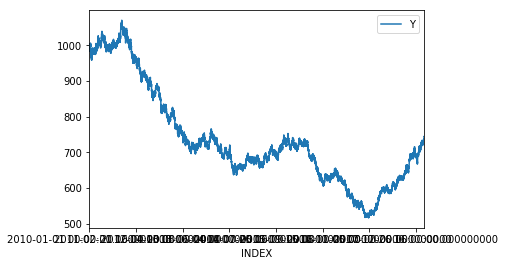

In [8]:
%matplotlib inline
start=timeit.default_timer()
df_raw = df_pal.collect()
df_raw.set_index(df_raw.columns[0], inplace=True)
df_raw=df_raw.astype(float)
ax = df_raw.plot()
ax.xaxis.set_major_locator(years)
print(timeit.default_timer()-start)

4.627003398956731


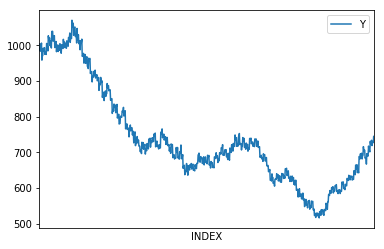

In [13]:
%matplotlib inline
start=timeit.default_timer()
df_sample = m4_sampling.m4_sampling(df_pal,200)
df_mod = df_sample.collect()
df_mod.set_index(df_mod.columns[0], inplace=True)
df_mod.sort_index(inplace=True)
df_mod=df_mod.astype(float)
ax = df_mod.plot()
ax.xaxis.set_major_locator(years)
print(timeit.default_timer()-start)